In [10]:
### Import of libraries

import numpy as np
import scipy as sc
from scipy import integrate

import matplotlib.pyplot as plt
newparams = {'figure.figsize': (8.0, 4.0), 'axes.grid': True,
             'lines.markersize': 8, 'lines.linewidth': 2,
             'font.size': 14}
plt.rcParams.update(newparams)

In [11]:
#partition
#return array with n segments
def partition(n):
    segments = np.random.rand(n-1)
    segments = np.sort(segments)
    return np.concatenate(([segments[0]], np.diff(segments), [1 - segments[-1]]))

#FEM with P1 as basis, with n segments
#let u have n+1 elements but u[0]=u[n+1]=0 and therfor not part of equation
def FEM(n,f,alfa,b,c,seg):  
    #Define Xk values
    #n+1 points
    Xk = np.concatenate(([0], np.cumsum(seg))) 
    
    
    #Define A
    #n-1 x n-1
    A = np.zeros((n-1,n-1))
    A += np.diag(-alfa/seg[1:-1] -b/2+  c*seg[1:-1]/6,-1)
    A += np.diag(alfa/seg[:-1] + c*seg[:-1]/3 + alfa/seg[1:] + c*seg[1:]/3)
    A += np.diag(-alfa/seg[1:-1]+b/2+c*seg[1:-1]/6,1)
        
    #Define F
    #calculate with simpson rule
    F = np.zeros(n-1,dtype=float)
    F = (2*f((Xk[:-2]+Xk[1:-1])/2,alfa,b,c)+f(Xk[1:-1],alfa,b,c))*seg[:-1]/6
    F += (2*f((Xk[1:-1]+Xk[2:])/2,alfa,b,c)+f(Xk[1:-1],alfa,b,c))*seg[1:]/6
        
    return Xk,np.concatenate(([0],np.linalg.solve(A,F),[0]))
    

#calculate integral with simpson rule
def L2(Xk,Yk):
    return sc.integrate.simpson(Yk**2,Xk)**(1/2)
  
#calculate integral with simpson rule
def H1(Xk,Yk):
    return (sc.integrate.simpson(Yk**2,x=Xk) + sc.integrate.simpson(np.gradient(Yk,Xk)**2,x=Xk))**(1/2)

#checks convergence by aplying quadistance points
def conv(U_exact_funk,f,alfa,b,c):
    n = 10
    k = 8
    max = n*2**k
    x = np.linspace(0,1,max*50)
    h_arr = np.zeros(k)
    error_H = np.zeros(k)
    error_L = np.zeros(k)
    
    for i in range(0, k):
        U_exact = U_exact_funk(x)
        Xk,U = FEM(n,f,alfa,b,c,np.ones(n)/n)
        U_interp = np.interp(x,Xk,U)
        error_H[i] = H1(x,U_exact-U_interp)
        error_L[i] = L2(x,U_exact-U_interp)
        h_arr[i] = 1/n
        n = n*2
    
    order_H = np.polyfit(np.log(h_arr),np.log((error_H)),1)[0]
    
    order_L = np.polyfit(np.log(h_arr),np.log((error_L)),1)[0]


    return h_arr, error_H, error_L, order_H, order_L

In [12]:
# Print A

def f_1(x,alfa,b,c):
    return 2*alfa+b*(-2*x+1)+c*(x-x**2)

def U_exact(x):
    return x-x**2

#constants
alfa =1
b = -1 
c = 3
n = 20

part = partition(n)

Xk, U = FEM(n,f_1,alfa,b,c,part)


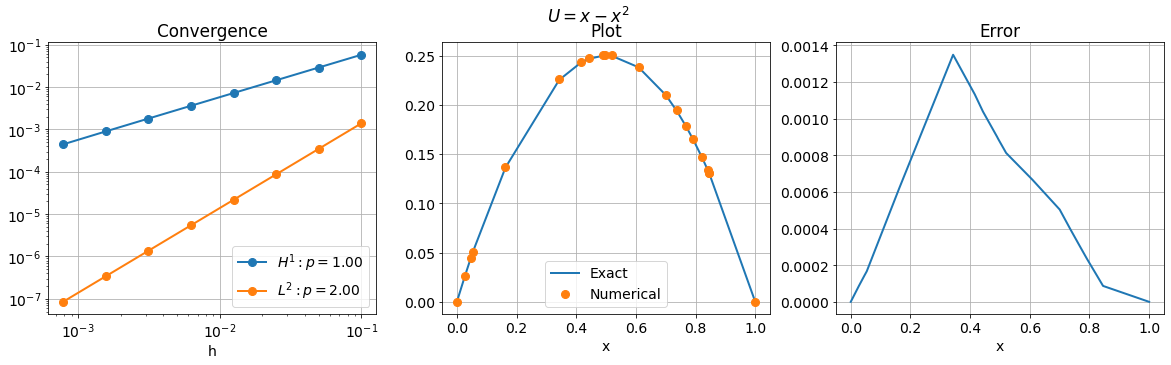

In [13]:
####### Testing FEM for U = x-x**2 ###################################################
def f_1(x,alfa,b,c):
    return 2*alfa+b*(-2*x+1)+c*(x-x**2)

def U_exact(x):
    return x-x**2

#constants
alfa =1
b = -1 #-2
c = 6
n = 20

h_arr_f1, error_H_f1, error_L_f1, order_H_f1, order_L_f1 = conv(U_exact,f_1,alfa,b,c)


# For equidistant nodes
#Xk, U = FEM(n,f_1,alfa,b,c,np.ones(n)/n)

# For non-evenly spaced nodes
Xk, U = FEM(n,f_1,alfa,b,c,part)

fig1, ax1 = plt.subplots(1, 3, figsize=(20, 5))
fig1.suptitle(r'$U = x-x^2$')

ax1[0].loglog(h_arr_f1, error_H_f1, 'o-',label=r'$H^1: p=${:.2f}'.format(order_H_f1))
ax1[0].loglog(h_arr_f1, error_L_f1, 'o-', label=r'$L^2: p=${:.2f}'.format(order_L_f1))
ax1[0].set_xlabel('h')
ax1[0].legend()
ax1[0].set_title(r'Convergence')

ax1[1].plot(Xk,U_exact(Xk))
ax1[1].plot(Xk, U, 'o')
ax1[1].legend(['Exact','Numerical'])
ax1[1].set_xlabel('x')
ax1[1].set_title('Plot')

ax1[2].plot(Xk, U-U_exact(Xk))
ax1[2].set_xlabel('x')
ax1[2].set_title('Error')

plt.savefig('first_func.png')
#plt.savefig('first_func_equi.png')





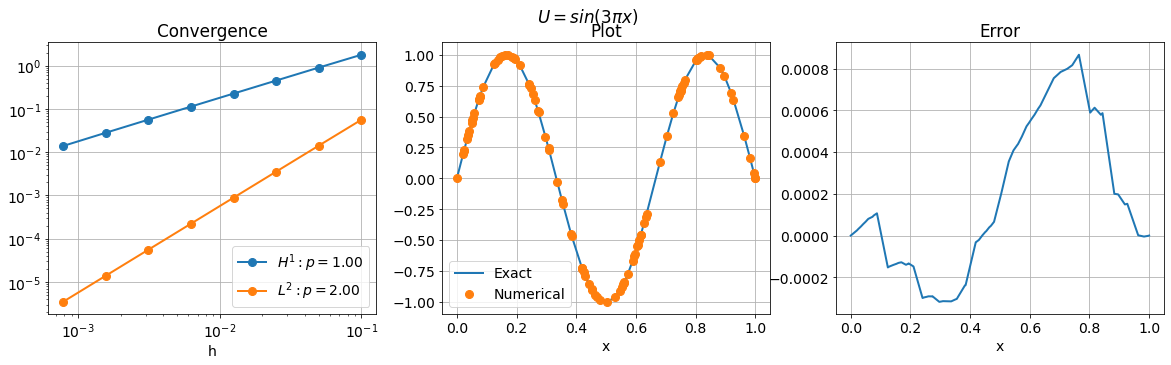

In [14]:

######## Testing FEM for U = sin(3πx) ##########################################################
def f_2(x,alfa,b,c):
    return 9*np.pi**2*alfa*np.sin(3*np.pi*x)+3*b*np.pi*np.cos(3*np.pi*x)+c*np.sin(3*np.pi*x)
   
def U_exact(x):
    return np.sin(3*np.pi*x)

#constants
alfa =1
b = 1
c = 1
n = 100

part = partition(n)

h_arr_f2, error_H_f2, error_L_f2, order_H_f2, order_L_f2 = conv(U_exact,f_2,alfa,b,c)

# Equidistant nodes 
#Xk, U = FEM(n,f_2,alfa,b,c,np.ones(n)/n)

# Non-evenly spaced nodes
Xk, U = FEM(n,f_2,alfa,b,c,part)

fig2, ax2 = plt.subplots(1, 3, figsize=(20, 5))

fig2.suptitle(r'$U =sin(3 \pi x)$')

ax2[0].loglog(h_arr_f2,error_H_f2, 'o-',label=r'$H^1: p=${:.2f}'.format(order_H_f1))
ax2[0].loglog(h_arr_f2,error_L_f2, 'o-',label=r'$L^2: p=${:.2f}'.format(order_L_f1))
ax2[0].set_xlabel('h')
ax2[0].legend()
ax2[0].set_title(r'Convergence')

ax2[1].plot(Xk,U_exact(Xk))
ax2[1].plot(Xk, U, 'o')
ax2[1].legend(['Exact','Numerical'])
ax2[1].set_xlabel('x')
ax2[1].set_title('Plot')

ax2[2].plot(Xk, U-U_exact(Xk))
ax2[2].set_xlabel('x')
ax2[2].set_title('Error')

plt.savefig('snd_func.png')

#plt.savefig('snd_func_equi.png')





In [15]:
#FEM with P1 as basis, with n segments
#let u have n+1 elements but u[0]=u[n+1]=0 and therfor not part of equation

def FEM_D(n,F_,alfa,b,c,seg):
    
    #Define Xk values
    #n+1 points
    Xk = np.concatenate(([0], np.cumsum(seg))) 
    
    
    #Define A
    #n-1 x n-1
    A = np.zeros((n-1,n-1))
    A += np.diag(-alfa/seg[1:-1] -b/2+  c*seg[1:-1]/6,-1)
    A += np.diag(alfa/seg[:-1] + c*seg[:-1]/3 + alfa/seg[1:] + c*seg[1:]/3)
    A += np.diag(-alfa/seg[1:-1]+b/2+c*seg[1:-1]/6,1)
    #print("A:",A)
    
    #Define F
    F = F_(Xk,seg,alfa,b,c)
    #print("F:",F)
    
    return Xk,np.concatenate(([0],np.linalg.solve(A,F),[0]))
    

#calculate integral with simpson rule
def L2(Xk,Yk):
    return sc.integrate.simpson(Yk**2,Xk)**(1/2)
  
#calculate integral with simpson rule
def H1(Xk,Yk):
    return (sc.integrate.simpson(Yk**2,x=Xk) + sc.integrate.simpson(np.gradient(Yk,Xk)**2,x=Xk))**(1/2)

#checks convergence by aplying quadistance points
def conv_D(U_exact_funk,F,alfa,beta,c):
    n = 10
    k = 5
    max = n*2**k
    x = np.linspace(0,1,max*5)
    h_arr = np.zeros(5)
    error_H = np.zeros(5)
    error_L = np.zeros(5)
    
    for i in range(0, k):
        U_exact = U_exact_funk(x)
        Xk,U = FEM_D(n-1,F,alfa,b,c,np.ones(n-1)/(n-1))
        U_interp = np.interp(x,Xk,U)
        error_H[i] = H1(x,U_exact-U_interp)
        error_L[i] = L2(x,U_exact-U_interp)
        h_arr[i] = 1/(n-1)
        n = n*2
    
    order_H = np.polyfit(np.log(h_arr),np.log((error_H)),1)[0]
    
    order_L = np.polyfit(np.log(h_arr),np.log((error_L)),1)[0]


    return h_arr, error_H, error_L, order_H, order_L




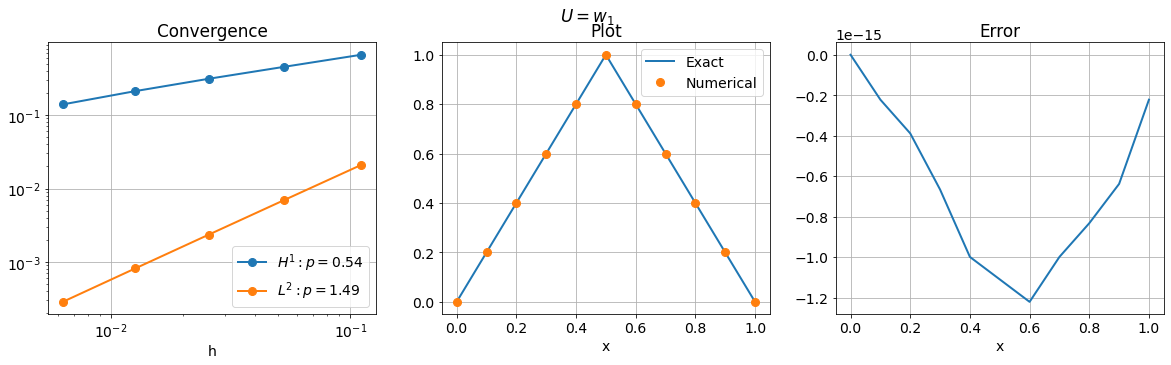

In [23]:

######################2d W1 ##########################################################################################
def U_exact_Vec(x):
    val = np.zeros(len(x))
    for i in range(len(x)):
        if(x[i]<1/2):
            val[i]=2*x[i]
        else:
            val[i]=2-2*x[i]
    return val

def U_exact(x):
    if x<1/2:
        return 2*x
    else:
        return 2*(1-x)

def U_exact_in(x):
    if x<1/2:
        return x**2
    else:
        return 2*x-x**2-1/2

def U_exact_in2(x):
    if x<1/2:
        return x**3/3
    else:
        return x**2-x**3/3-x/2+1/12
    

#Assume x is a partition starting with 0 ending with 1
#sup is the length of the intervals inbetween
#val is of length len(x)-2
def F_w1(x,seg,alfa,b,c):
    val = np.zeros(len(x)-2)
    for i in range(1,len(x)-1):
        val[i-1] = alfa*((U_exact(x[i])-U_exact(x[i-1]))/seg[i-1] +  (U_exact(x[i])-U_exact(x[i+1]))/seg[i])
        val[i-1] += -b*((U_exact_in(x[i])-U_exact_in(x[i-1]))/seg[i-1] +  (U_exact_in(x[i])-U_exact_in(x[i+1]))/seg[i])
        val[i-1] += -c*((U_exact_in2(x[i])-U_exact_in2(x[i-1]))/seg[i-1] +  (U_exact_in2(x[i])-U_exact_in2(x[i+1]))/seg[i])
    return val

#constants
alfa =1
b = 1
c = 1

n = 10

h_arr_w1, error_H_w1, error_L_w1, order_H_w1, order_L_w1 = conv_D(U_exact_Vec,F_w1,alfa,b,c)

Xk,U = FEM_D(n,F_w1,alfa,b,c,np.ones(n)/n)

fig4, ax4 = plt.subplots(1, 3, figsize=(20, 5))
fig4.suptitle(r'$U = w_1$')

ax4[0].loglog(h_arr_w1, error_H_w1, 'o-',label=r'$H^1: p=${:.2f}'.format(order_H_w1))
ax4[0].loglog(h_arr_w1, error_L_w1, 'o-', label=r'$L^2: p=${:.2f}'.format(order_L_w1))
ax4[0].set_xlabel('h')
ax4[0].legend()
ax4[0].set_title(r'Convergence')

ax4[1].plot(Xk,U_exact_Vec(Xk))
ax4[1].plot(Xk, U, 'o')
ax4[1].legend(['Exact', 'Numerical'])
ax4[1].set_xlabel('x')
ax4[1].set_title('Plot')

ax4[2].plot(Xk, U-U_exact_Vec(Xk))
ax4[2].set_xlabel('x')
ax4[2].set_title('Error')

plt.savefig('w_1_func.png')


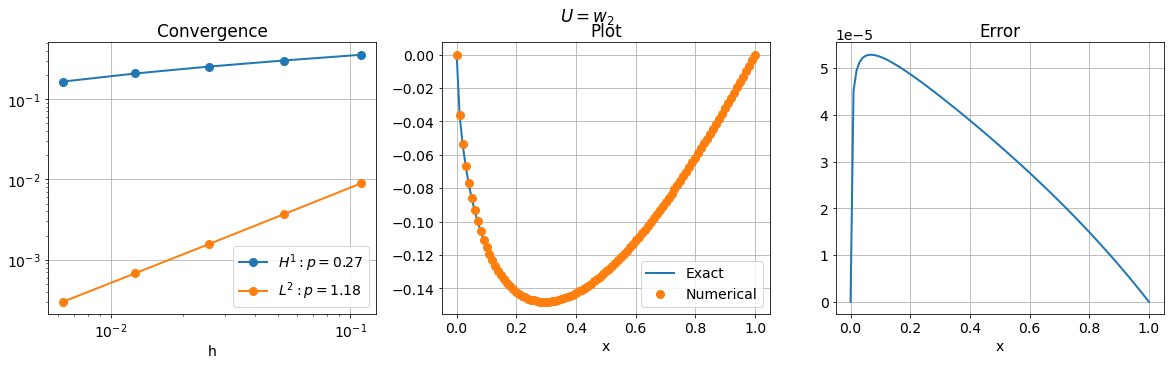

In [17]:


##################### 2D W2 ###################################################################################
def U_exact(x):
    return x-x**(2/3)

def U_exact_in(x):
    return x**2/2-x**(5/3)/(5/3)

def U_exact_in2(x):
    return x**3/6-x**(8/3)/(40/9)

#constants
alfa =1
b = 1
c = 1
n = 100


h_arr_w2, error_H_w2, error_L_w2, order_H_w2, order_L_w2 = conv_D(U_exact,F_w1,alfa,b,c)

Xk,U = FEM_D(n,F_w1,alfa,b,c,np.ones(n)/n)

fig5, ax5 = plt.subplots(1, 3, figsize=(20, 5))
fig5.suptitle(r'$U = w_2$')

ax5[0].loglog(h_arr_w2, error_H_w2, 'o-', label=r'$H^1: p=${:.2f}'.format(order_H_w2))
ax5[0].loglog(h_arr_w2, error_L_w2, 'o-', label=r'$L^2: p=${:.2f}'.format(order_L_w2))
ax5[0].set_xlabel('h')
ax5[0].legend()
ax5[0].set_title(r'Convergence')

ax5[1].plot(Xk,U_exact(Xk))
ax5[1].plot(Xk, U, 'o')
ax5[1].legend(['Exact', 'Numerical'])
ax5[1].set_xlabel('x')
ax5[1].set_title('Plot')

ax5[2].plot(Xk, U-U_exact(Xk))
ax5[2].set_xlabel('x')
ax5[2].set_title('Error')

plt.savefig('w_2_func.png')


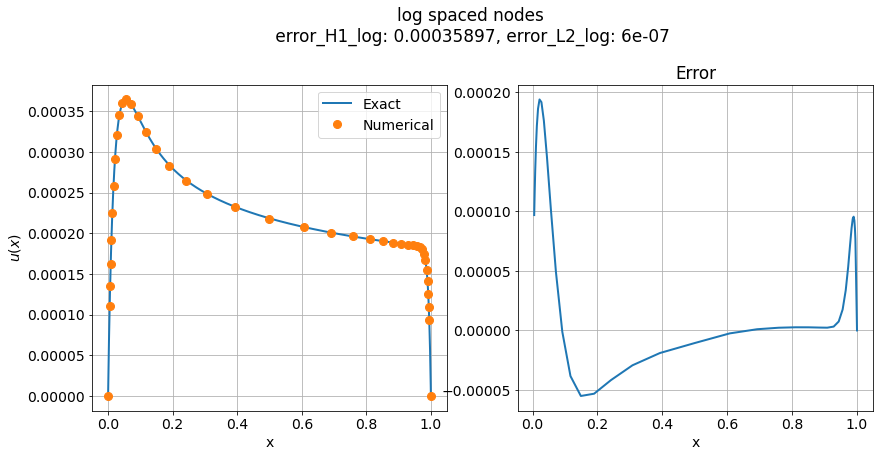

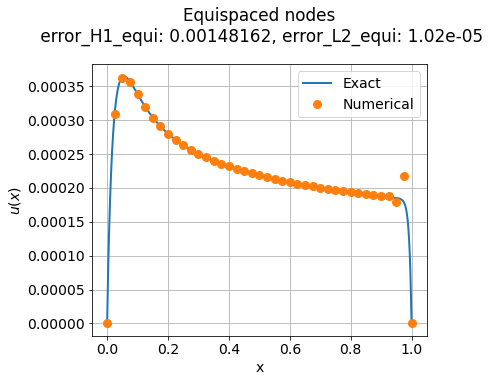

In [18]:

########### Task 2E ##############################################################################
def f_E(x,alfa,b,c):
    #return 1
    return x**(-1/4)
  

#constants
alfa = 1
b = 100
c = 5500
n = 40 #
k = 100 #n*(k+1) used for test solution
Xk_log = np.logspace(-2,0,int(n/2))
Xk_log_k = np.logspace(-3,0,int((n+(n-1)*k)/2))

tmp  = np.concatenate(([Xk_log[0]],np.diff(Xk_log)))/2
Xk_log,U_log = FEM(n,f_E,alfa,b,c,np.concatenate((tmp,np.flip(tmp))))
tmp  = np.concatenate(([Xk_log_k[0]],np.diff(Xk_log_k)))/2
Xk_exact,U_exact = FEM(n+(n-1)*k,f_E,alfa,b,c,np.concatenate((tmp,np.flip(tmp))))

U_log_interp = np.interp(Xk_exact,Xk_log,U_log)
error_H_log = H1(Xk_exact,U_log_interp-U_exact)
error_L2_log = L2(Xk_exact,U_log_interp-U_exact)

fig3, ax3 = plt.subplots(1, 2, figsize=(14, 6))
fig3.suptitle(f'log spaced nodes\n error_H1_log: {np.around(error_H_log, decimals=8)}, error_L2_log: {np.around(error_L2_log, decimals=8)}', y=1.06)


ax3[0].plot(Xk_exact,U_exact)
ax3[0].plot(Xk_log,U_log, 'o')
ax3[0].legend(['Exact','Numerical'])
ax3[0].set_xlabel('x')
ax3[0].set_ylabel(r'$u(x)$')

ax3[1].plot(Xk_log[1:],U_log[1:]-U_exact[1::k+1])
ax3[1].set_title('Error')
ax3[1].set_xlabel('x')

plt.savefig('2e_logspace_fig2')

#equidistance
Xk_equ,U_equ = FEM(n,f_E,alfa,b,c,np.ones(n)/n)

U_equ_interp = np.interp(Xk_exact,Xk_equ,U_equ)
error_H_equ = H1(Xk_exact,U_equ_interp-U_exact)
error_L2_equ = L2(Xk_exact,U_equ_interp-U_exact)

fig4 = plt.figure(figsize=(6, 5))
plt.title(f'Equispaced nodes\n error_H1_equi: {np.around(error_H_equ, decimals=8)}, error_L2_equi: {np.around(error_L2_equ, decimals=8)}', y=1.06)

plt.plot(Xk_exact,U_exact)
plt.plot(Xk_equ,U_equ, 'o')
plt.legend(['Exact','Numerical'])
plt.xlabel('x')
plt.ylabel(r'$u(x)$')
plt.show()
fig4.savefig('2e_equispace_fig2')
